In [1]:
import os
import sys
import datetime
import itertools
from tqdm import tqdm
import numpy as np
import pandas as pd
import random
import glob

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import plotly.graph_objs as go
import plotly.express as px
import seaborn as sns

import tensorflow as tf
from tensorflow import keras
from tensorflow.random import set_seed
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.callbacks import TensorBoard, ModelCheckpoint
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img, array_to_img
from tensorflow.python.keras.layers import Dense, Conv2D, Flatten, Dropout, MaxPooling2D, ZeroPadding2D
from sklearn.metrics import confusion_matrix, plot_confusion_matrix, roc_curve, auc, multilabel_confusion_matrix
from sklearn.utils.class_weight import compute_class_weight
from sklearn.model_selection import train_test_split
from sklearn import metrics

import visualkeras
from collections import defaultdict

set_seed(42)
np.random.seed(42)


In [2]:
physical_devices = tf.config.experimental.list_physical_devices('GPU')
print("Num GPUs Available: ", len(physical_devices))
tf.config.experimental.set_memory_growth(physical_devices[0], True)

Num GPUs Available:  1


In [3]:
def plot_results(results):
  """Function to convert a models results into a dataframe and plot them to show the both the accuracy and validation accuracy, as well as the loss and validation loss over epochs.

  Args:
      results_dataframe (dataframe): 
  """

  results_dataframe = pd.DataFrame(results)

  fig = px.line(results_dataframe, x=results_dataframe.index, y=["accuracy","val_accuracy"])
  fig.update_layout(title='Accuracy and Validation Accuracy over Epochs',
                    xaxis_title='Epoch',
                    yaxis_title='Percentage',
                )
  fig.update_traces(mode='lines+markers')
  fig.show()

  fig = px.line(results_dataframe, x=results_dataframe.index, y=['loss','val_loss'])
  fig.update_layout(title='Loss and Validation Loss over Epochs',
                    xaxis_title='Epoch',
                    yaxis_title='Loss'
                )
  fig.update_traces(mode='lines+markers')
  fig.show()

def plotImages(images_arr, labels_arr):
    # labels_arr = ['Normal: 0' if label == 0 else 'Pneumonia: 1' for label in labels_arr]
    fig, axes = plt.subplots(1, 10, figsize=(20,20))
    # axes = axes.flatten()
    for img, label, ax in zip(images_arr, 
                              labels_arr, 
                              axes):
        ax.imshow(img)
        ax.set_title(label, size=18)
        ax.axis('off')
    plt.tight_layout()
    plt.show()

def evaluate_results(model): 
    labels = ['East','South', 'Mid-West', 'West']
    predictions = model.predict(X_test).argmax(axis=1)
    cm = metrics.confusion_matrix(y_test.argmax(axis=1), 
                                    predictions,
                                    normalize="pred")

    ax = sns.heatmap(cm, cmap='Blues',annot=True,square=True)
    ax.set(xlabel='Predicted Class',ylabel='True Class')
    ax.set_xticklabels(labels)
    ax.set_yticklabels(labels)
    print(metrics.classification_report(y_test.argmax(axis=1), predictions))

def print_shapes(x1, y1, x2, y2):
    print(x1.shape)
    print(y1.shape)
    print(x2.shape)
    print(y2.shape)
# def prepare_confusion_matrix(model):

#     predictions = model.predict(X_test).round()
#     cm = confusion_matrix(y_test, predictions)
#     return cm, predictions
    # test_generator.class_indices
  


# Setting up paths

In [4]:

train_east = os.path.join('../capstone-data/music - color/TRAIN/East')
train_west = os.path.join('../capstone-data/music - color/TRAIN/West')
train_mid_west = os.path.join('../capstone-data/music - color/TRAIN/Mid-west')
train_south = os.path.join('../capstone-data/music - color/TRAIN/South')

all_paths = [train_east, train_mid_west, train_south ,train_west]


# Show number of files for each class in each folder

In [5]:

for path in all_paths:
    png_count = len(glob.glob(os.path.join(path, '**/*.png'), recursive=True))
    print(path,':', png_count)    

../capstone-data/music - color/TRAIN/East : 1029
../capstone-data/music - color/TRAIN/Mid-west : 711
../capstone-data/music - color/TRAIN/South : 892
../capstone-data/music - color/TRAIN/West : 1325


# Normalize image size and load into generator

In [6]:
# All images will be rescaled by 1./255
train_datagen = ImageDataGenerator(rescale=1./255)


train_generator = train_datagen.flow_from_directory('../capstone-data/music - color/TRAIN/', 
                                                    target_size=(64, 64), 
                                                    batch_size=4273, 
                                                    class_mode='categorical',
                                                    subset='training',
                                                    shuffle=True)

X_all,y_all = next(train_generator)


Found 3962 images belonging to 4 classes.


In [7]:

X_train, X_test, y_train, y_test = train_test_split(X_all, y_all, test_size=0.4, random_state=42, shuffle=True)
print_shapes(X_train, y_train, X_test, y_test)

(2377, 64, 64, 3)
(2377, 4)
(1585, 64, 64, 3)
(1585, 4)


In [8]:
X_test, X_val, y_test, y_val = train_test_split(X_test, y_test, test_size=0.4, random_state=42, shuffle=True) 
print_shapes(X_test, y_test, X_val, y_val)

(951, 64, 64, 3)
(951, 4)
(634, 64, 64, 3)
(634, 4)


In [9]:
np.argmax(y_train, axis=1)

array([3, 3, 0, ..., 0, 0, 0], dtype=int64)

In [10]:
weights = compute_class_weight('balanced', np.unique(np.argmax(y_train, axis=1)), np.argmax(y_train, axis=1))
weights_dict = dict(zip(np.unique(np.argmax(y_train, axis=1)), weights))
weights_dict

{0: 0.9402689873417721,
 1: 1.4250599520383693,
 2: 1.0903669724770642,
 3: 0.7589399744572158}

# Show pictures

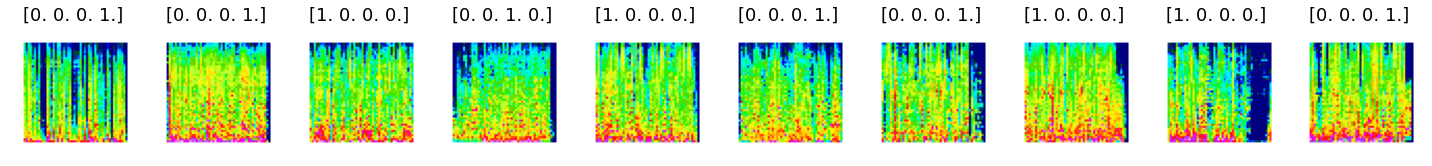

{'East': 0, 'Mid-West': 1, 'South': 2, 'West': 3}


In [11]:
plotImages(X_train, y_train)
# print(y_train[:10])
# print(X_train[0].shape)
print(train_generator.class_indices)

In [12]:
## Verify labels

# Begin modeling

# Model 1

This is a single convolutional layer with a single connected dense layer just to test how well it works to start off.

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 62, 62, 64)        1792      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 31, 31, 64)        0         
_________________________________________________________________
flatten (Flatten)            (None, 61504)             0         
_________________________________________________________________
dense (Dense)                (None, 64)                3936320   
_________________________________________________________________
dense_1 (Dense)              (None, 4)                 260       
Total params: 3,938,372
Trainable params: 3,938,372
Non-trainable params: 0
_________________________________________________________________
Instructions for updating:
use `tf.profiler.experimental.stop` instead.
Instructions for updating:
This property

              precision    recall  f1-score   support

           0       0.38      0.47      0.42       239
           1       0.25      0.46      0.32       176
           2       0.57      0.25      0.35       219
           3       0.50      0.36      0.42       317

    accuracy                           0.38       951
   macro avg       0.42      0.39      0.38       951
weighted avg       0.44      0.38      0.38       951

Wall time: 13.8 s


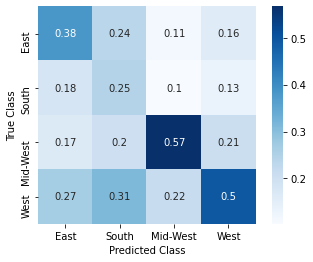

In [13]:
%%time
earlystop = tf.keras.callbacks.EarlyStopping(patience=3, verbose=True)
Adam_32_32_32_D3_64 = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(64, (3,3), activation='relu', input_shape=(64, 64, 3)),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(4, activation='softmax')
])

Adam_32_32_32_D3_64.summary()
Adam_32_32_32_D3_64.compile(loss='categorical_crossentropy',
              optimizer="Adam",
              metrics=['accuracy',tf.keras.metrics.Recall()])

checkpoint = ModelCheckpoint(filepath=r'../capstone-data/checkpoints/Adam_32_32_32_D3_64_', verbose=0, save_best_only=True, mode='auto')
tensorboard = TensorBoard(log_dir=f'../capstone-data/logs/Adam_32_32_32_D3_64_{datetime.datetime.now().strftime("%Y%m%d-%H%M%S")}')
history1 = Adam_32_32_32_D3_64.fit(
      X_train, 
      y_train,
      batch_size=64,
      epochs=200,
      verbose=0,
      class_weight=weights_dict,
      callbacks=[earlystop, tensorboard, checkpoint],
      validation_data=(X_val, y_val))

plot_results(history1.history)
evaluate_results(Adam_32_32_32_D3_64)


Unsurprisingly it performed poorly, classifying each piece into the West region.

## Model 2

I've added 2 additional convolutional layers and adjusted the neurons to 32,32 and 128. I've also reduced the dense layer from 64 to 32.

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 62, 62, 32)        896       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 31, 31, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 29, 29, 32)        9248      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 12, 12, 128)       36992     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 6, 6, 128)         0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 4608)             

              precision    recall  f1-score   support

           0       0.00      0.00      0.00       239
           1       0.22      0.35      0.27       176
           2       0.27      0.83      0.41       219
           3       0.00      0.00      0.00       317

    accuracy                           0.26       951
   macro avg       0.12      0.29      0.17       951
weighted avg       0.10      0.26      0.14       951

Wall time: 3.97 s


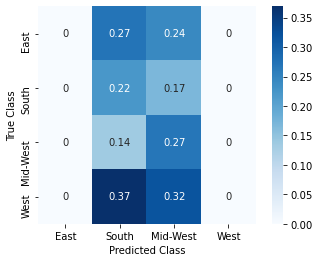

In [14]:
%%time
Adam_32_32_128_D32 = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(32, (3,3), activation='relu', input_shape=(64, 64, 3)),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Conv2D(32, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),

    tf.keras.layers.Flatten(),

    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(4, activation='softmax')
])

Adam_32_32_128_D32.summary()
Adam_32_32_128_D32.compile(loss='categorical_crossentropy',
              optimizer="Adam",
              metrics=['accuracy',tf.keras.metrics.Recall()])

checkpoint = ModelCheckpoint(filepath=r'../capstone-data/checkpoints/Adam_32_32_128_D32', verbose=0, save_best_only=True, mode='auto')
tensorboard = TensorBoard(log_dir=f'../capstone-data/logs/Adam_32_32_128_D32{datetime.datetime.now().strftime("%Y%m%d-%H%M%S")}')
history2 = Adam_32_32_128_D32.fit(
      X_train, 
      y_train,
      batch_size=128,
      epochs=200,
      verbose=0,
      class_weight=weights_dict,
      callbacks=[earlystop, tensorboard, checkpoint],
      validation_data=(X_val, y_val))

plot_results(history2.history)
evaluate_results(Adam_32_32_128_D32)


This model performed much better than the first at least getting a mjority of the correct data points classified.

## Model 3

I've kept the convolutional layers the same but adjusted the dense layers using two layers before the output at 128 and 64 to see what the effect would be on the model

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 62, 62, 32)        896       
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 31, 31, 32)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 29, 29, 32)        9248      
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 12, 12, 128)       36992     
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 6, 6, 128)         0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 4608)             

              precision    recall  f1-score   support

           0       0.38      0.46      0.41       239
           1       0.25      0.44      0.32       176
           2       0.54      0.40      0.46       219
           3       0.54      0.32      0.40       317

    accuracy                           0.40       951
   macro avg       0.43      0.40      0.40       951
weighted avg       0.44      0.40      0.40       951

Wall time: 11.3 s


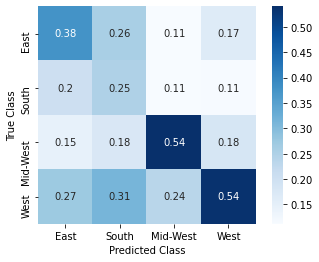

In [15]:
%%time
Adam_32_32_128_D16 = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(32, (3,3), activation='relu', input_shape=(64, 64, 3)),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Conv2D(32, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(4, activation='softmax')
])

Adam_32_32_128_D16.summary()
Adam_32_32_128_D16.compile(loss='categorical_crossentropy',
              optimizer="Adam",
              metrics=['accuracy',tf.keras.metrics.Recall()])

checkpoint = ModelCheckpoint(filepath=r'../capstone-data/checkpoints/Adam_32_32_128_D16', verbose=0, save_best_only=True, mode='auto')
tensorboard = TensorBoard(log_dir=f'../capstone-data/logs/Adam_32_32_128_D16{datetime.datetime.now().strftime("%Y%m%d-%H%M%S")}')
history3 = Adam_32_32_128_D16.fit(
      X_train, 
      y_train,
      batch_size=128,
      epochs=200,
      verbose=0,
      class_weight=weights_dict,
      callbacks=[earlystop, tensorboard, checkpoint],
      validation_data=(X_val, y_val))

plot_results(history3.history)
evaluate_results(Adam_32_32_128_D16)


It seems that the model has a similar accuracy but much less balanced predictions.

### Here I'm adjusting the image size from 64 x 64 up to 256 x 256 hoping that the additional resolution will allow it to pick up more nuance in the images.

In [16]:
train_generator = train_datagen.flow_from_directory('../capstone-data/music - color/TRAIN/',
                                                  target_size=(256, 256), 
                                                  batch_size=4273, 
                                                  class_mode='categorical',
                                                  subset='training',
                                                  shuffle=True)
X_all,y_all = next(train_generator)
X_train, X_test, y_train, y_test = train_test_split(X_all, y_all, test_size=0.1, random_state=42, shuffle=True)
X_test, X_val, y_test, y_val = train_test_split(X_test, y_test, test_size=0.2, random_state=42, shuffle=True) 

Found 3962 images belonging to 4 classes.


Model: "sequential_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_34 (Conv2D)           (None, 250, 250, 32)      4736      
_________________________________________________________________
max_pooling2d_34 (MaxPooling (None, 83, 83, 32)        0         
_________________________________________________________________
conv2d_35 (Conv2D)           (None, 77, 77, 32)        50208     
_________________________________________________________________
max_pooling2d_35 (MaxPooling (None, 25, 25, 32)        0         
_________________________________________________________________
conv2d_36 (Conv2D)           (None, 19, 19, 32)        50208     
_________________________________________________________________
max_pooling2d_36 (MaxPooling (None, 6, 6, 32)          0         
_________________________________________________________________
flatten_12 (Flatten)         (None, 1152)            

              precision    recall  f1-score   support

           0       0.60      0.37      0.46        81
           1       0.37      0.31      0.33        62
           2       0.46      0.65      0.54        72
           3       0.58      0.64      0.60       102

    accuracy                           0.51       317
   macro avg       0.50      0.49      0.48       317
weighted avg       0.51      0.51      0.50       317

Wall time: 1min 30s


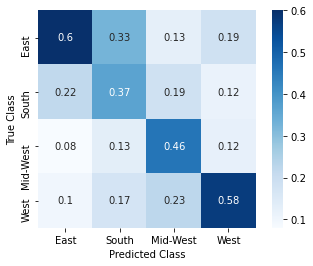

In [26]:
%%time
Adam256_32_32_32_D3_64 = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(32, (7,7), activation='relu', input_shape=(256, 256, 3)),
    tf.keras.layers.MaxPooling2D(3,3),
    tf.keras.layers.Conv2D(32, (7,7), activation='relu'),
    tf.keras.layers.MaxPooling2D(3,3),
    tf.keras.layers.Conv2D(32, (7,7), activation='relu'),
    tf.keras.layers.MaxPooling2D(3,3),

    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(4, activation='softmax')
])

Adam256_32_32_32_D3_64.summary()
Adam256_32_32_32_D3_64.compile(loss='categorical_crossentropy',
              optimizer="Adam",
              metrics=['accuracy',tf.keras.metrics.Recall()])

earlystop = tf.keras.callbacks.EarlyStopping(patience=3, verbose=True)
checkpoint = ModelCheckpoint(filepath=r'../capstone-data/checkpoints/Adam_32_32_32_D3_64_', verbose=0, save_best_only=True, mode='auto')
tensorboard = TensorBoard(log_dir=f'../capstone-data/logs/Adam_32_32_32_D3_64_{datetime.datetime.now().strftime("%Y%m%d-%H%M%S")}')
history1 = Adam256_32_32_32_D3_64.fit(
      X_train, 
      y_train,
      batch_size=128,
      epochs=200,
      verbose=0,
      class_weight=weights_dict,
      callbacks=[earlystop, tensorboard, checkpoint],
      validation_data=(X_val, y_val))

plot_results(history1.history)
evaluate_results(Adam256_32_32_32_D3_64)

This seems to be the best model with an overall accuracy that is higher than previous models and still much more even across the board.

## Conclusion

In the end the model responded better with a larger input size (256x256 vs 64x64). I think having a higher resolution image to scan through makes it easier for the model to identify nuance in what looks to me to be an intricate mess of colors. I tried dozens of different architectures and ultimately landed on this one that I found the best results. I think having multiple convolutional layers along with the higher resolution offer more opportunity to identify features and patterns within the image and ultimately reach an accuracy of 56%